C:\Users\MJ\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


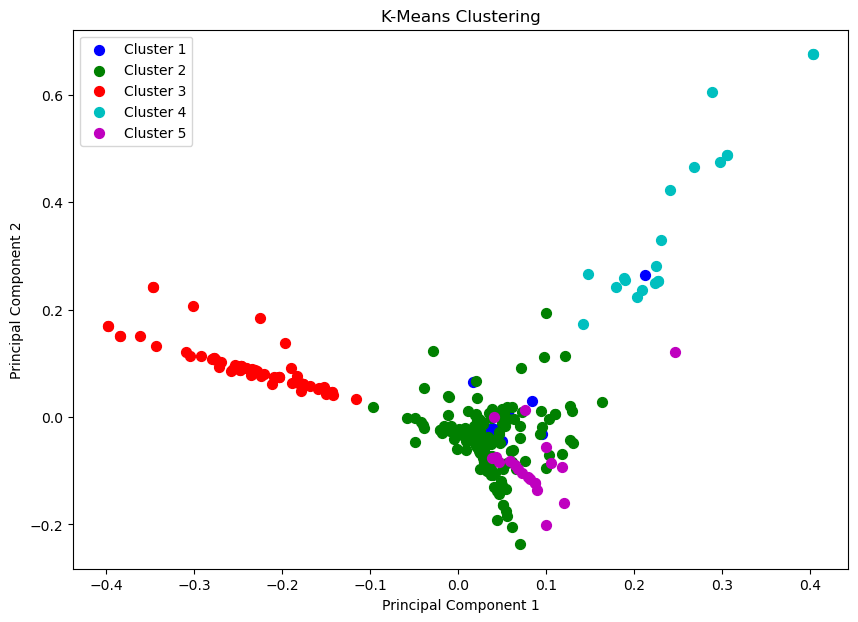

[0.39380398787515164]
....map@_10....
0.39380398787515164
[0.39380398787515164, 0.23733150826259566]
....map@_10....
0.31556774806887367
[0.39380398787515164, 0.23733150826259566, 0.1970684452658269]
....map@_10....
0.2760679804678581


In [2]:
import os
import json
import tkinter as tk
from tkinter import scrolledtext
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
import difflib
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import json
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# قراءة البيانات من ملف JSONL
file_path = "C:\\Users\\MJ\\Desktop\\IR\\lotte\\lifestyle\\dev\\qas.search.jsonl"
data = []
with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        record = json.loads(line)
        data.append(record['query'])  

# تحويل النصوص إلى متجهات TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(data)

# تنفيذ خوارزمية K-Means للتجميع
num_clusters = 5 # يمكنك تغيير عدد المجموعات هنا
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
y_kmeans = kmeans.fit_predict(X)

# تقليل الأبعاد باستخدام PCA لعرض البيانات في رسم بياني ثنائي الأبعاد
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X.toarray())

# عرض النتائج باستخدام matplotlib مع تمييز المجموعات بالألوان
plt.figure(figsize=(10, 7))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i in range(num_clusters):
    points = principal_components[y_kmeans == i]
    plt.scatter(points[:, 0], points[:, 1], s=50, c=colors[i % len(colors)], label=f'Cluster {i+1}')
plt.title('K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

class TextCleaning:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))

    def clean_text(self, text):
        text = re.sub(r'\b(about|above|across|after|against|along|amid|among|an|and|as|at|be|because|been|before|being|below|beneath|beside|between|beyond|but|by|down|during|for|from|in|inside|into|like|near|of|off|on|onto|out|over|past|since|throughout|to|toward|underneath|until|up|upon|with)\b', '', text)
        text = re.sub(r'\b(a|an|the)\b', '', text)
        text = ' '.join([word for word in word_tokenize(text) if word.lower() not in self.stop_words])
        return text.strip()

def load_and_clean_data(input_path):
    with open(input_path, 'r') as file:
        data = file.readlines()

    cleaning_class = TextCleaning()
    cleaned_data = []
    raw_data = []

    for one_text in data:
        cleaned_text = cleaning_class.clean_text(one_text)
        if cleaned_text:
            cleaned_data.append(cleaned_text)
            raw_data.append(one_text)

    return cleaned_data, raw_data
#The second question: Representing data in the form of vectors
def prepare_data(cleaned_data, raw_data):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(cleaned_data)

    ids_data = [json.loads(line).get('_id', f"document{i}") for i, line in enumerate(raw_data)]

    return vectorizer, tfidf_matrix, ids_data

relevant_docs = {}
#A class containing the interface and buttons

class Application(tk.Tk):
    def __init__(self):
        super().__init__()

        self.title("Information Retrieval System")
        self.geometry("700x700")

        self.query_label = tk.Label(self, text="Enter your query:")
        self.query_label.pack()

        self.query_entry = tk.Entry(self)
        self.query_entry.pack()

        self.search_button = tk.Button(self, text="Search", command=self.search)
        self.search_button.pack()

        self.suggestions_button = tk.Button(self, text="Get Suggestions", command=self.get_suggestions)
        self.suggestions_button.pack()

        self.results_text = scrolledtext.ScrolledText(self, width=70, height=15)
        self.results_text.pack()

        self.metrics_text = tk.Text(self, height=10, width=70)
        self.metrics_text.pack()

        self.queries_searched = []
        self.precision_list = []
        self.recall_list = []
        self.average_precision_list = []
        self.reciprocal_rank_list = []

        self.dataset_var = tk.StringVar(self)
        self.dataset_var.set("Select Dataset")
        self.dataset_menu = tk.OptionMenu(self, self.dataset_var, "Dataset 1", "Dataset 2", command=self.load_dataset)
        self.dataset_menu.pack(side=tk.TOP, anchor=tk.NE)

        self.clean_button = tk.Button(self, text="Clean and Represent Data", command=self.clean_and_represent_data)
        self.clean_button.pack()

        self.index_button = tk.Button(self, text="Index Data", command=self.index_data)
        self.index_button.pack()

        self.calculate_metrics_button = tk.Button(self, text="Calculate Overall Metrics", command=self.calculate_overall_metrics)
        self.calculate_metrics_button.pack()

        self.vectorizer = None
        self.tfidf_matrix = None
        self.ids_data = None
        self.cleaning_class = TextCleaning()

    def load_dataset(self, dataset_choice):
        if dataset_choice == "Dataset 1":
            self.input_path = 'C:\\Users\\MJ\\Desktop\\IR\\lotte\\lifestyle\\dev\\qas.search.jsonl'
        elif dataset_choice == "Dataset 2":
            self.input_path = 'C:\\Users\\MJ\\Desktop\\IR\\webis-touche2020\\queries.jsonl'
        else:
            return

        self.results_text.insert(tk.INSERT, f"Selected {dataset_choice}\n")

        self.queries_searched = []
        self.precision_list = []
        self.recall_list = []
        self.average_precision_list = []
        self.reciprocal_rank_list = []
        relevant_docs.clear()

    def clean_and_represent_data(self):
        if not hasattr(self, 'input_path') or not self.input_path:
            self.results_text.insert(tk.INSERT, "Please select a dataset first.\n")
            return

        cleaned_data, raw_data = load_and_clean_data(self.input_path)

        if not cleaned_data:
            self.results_text.insert(tk.INSERT, "Loaded dataset is empty after cleaning.\n")
            return

        corpus_data = cleaned_data

        final_results = []

        vectorizer = TfidfVectorizer()
        vectorizer.fit(corpus_data)

        for doc_id, doc_val in enumerate(corpus_data):
            vector = vectorizer.transform([doc_val]).toarray()
            distribution = vector[0]
            if not all(v == 0 for v in distribution):
                final_results.append({
                    "id_doc": doc_id,
                    "vector_doc": vector.tolist(),
                    "distribution_doc": distribution.tolist()
                })

        path_of_outer_dir = 'C:/Users/MJ/Desktop/IR'

        if not os.path.exists(path_of_outer_dir):
            os.makedirs(path_of_outer_dir)

        output_file_path = os.path.join(path_of_outer_dir, 'processed_data.json')

        with open(output_file_path, 'w') as output_file:
            json.dump(final_results, output_file, indent=4)

        self.results_text.insert(tk.INSERT, "Data cleaned and represented successfully.\n")
        self.results_text.insert(tk.INSERT, f"Saved to {output_file_path}\n")

        self.vectorizer = vectorizer
        self.tfidf_matrix = vectorizer.transform(corpus_data)
        self.ids_data = [json.loads(line).get('_id', f"document{i}") for i, line in enumerate(raw_data)]

    def index_data(self):
        if self.vectorizer is None or self.tfidf_matrix is None:
            self.results_text.insert(tk.INSERT, "Please clean and represent the data first.\n")
            return

        index_dir = 'C:/Users/MJ/Desktop/IR/fileindex'
        if not os.path.exists(index_dir):
            os.makedirs(index_dir)

        index_file_path = os.path.join(index_dir, 'index.json')

        index_data = {
            "ids_data": self.ids_data,
            "tfidf_matrix": self.tfidf_matrix.toarray().tolist()
        }

        with open(index_file_path, 'w') as index_file:
            json.dump(index_data, index_file, indent=4)

        self.results_text.insert(tk.INSERT, "Data indexed successfully.\n")
        self.results_text.insert(tk.INSERT, f"Saved to {index_file_path}\n")

        self.queries_searched = []
        self.precision_list = []
        self.recall_list = []
        self.average_precision_list = []
        self.reciprocal_rank_list = []
        self.average_precision_list_for_all_query=[]
        relevant_docs.clear()

    def search(self):
        if self.vectorizer is None or self.tfidf_matrix is None:
            self.results_text.insert(tk.INSERT, "Please load a dataset first.\n")
            return

        query = self.query_entry.get()
        self.queries_searched.append(query)

        cleaned_query = self.cleaning_class.clean_text(query)
        query_vector = self.vectorizer.transform([cleaned_query])

        scores = cosine_similarity(query_vector, self.tfidf_matrix).flatten()
        sorted_indices = np.argsort(scores)[::-1]

        filtered_results = [(self.ids_data[idx], scores[idx]) for idx in sorted_indices if scores[idx] > 0.0]
        top_10_results = filtered_results[:10]
        results = [doc_id for doc_id, score in top_10_results]

        if query not in relevant_docs and results:
            relevant_docs[query] = results

        relevant_documents = relevant_docs.get(query, [])

        precision_at_10 = sum(1 for doc_id in results if doc_id in relevant_documents) / 10
        self.precision_list.append(precision_at_10)

        recall_at_10 = sum(1 for doc_id in results if doc_id in relevant_documents) / len(filtered_results) if relevant_documents else 0
        self.recall_list.append(recall_at_10)

        relevant_count = 0
        average_precision_at_10 = 0
        sum_score=0
        
        for i, score in top_10_results:
                relevant_count += 1
                sum_score+=score
                average_precision_at_10=sum_score/relevant_count
        self.average_precision_list_for_all_query.append(average_precision_at_10)

     
        print(self.average_precision_list_for_all_query)

        count_map=0
        sum_values=0
        for idx, value in enumerate(self.average_precision_list_for_all_query, start=1):
            count_map+=1
            sum_values+=value
        map_10=sum_values/count_map
        
   

        reciprocal_rank = 0
        for i, doc_id in enumerate(results, 1):
            if doc_id in relevant_documents:
                reciprocal_rank = 1 / i
                break
        self.reciprocal_rank_list.append(reciprocal_rank)

        self.results_text.delete(1.0, tk.END)
        self.results_text.insert(tk.INSERT, "Top 10 Relevant Documents:\n")
        self.results_text.insert(tk.INSERT, "\n".join([f"{doc_id}: {score:.4f}" for doc_id, score in top_10_results]))

        self.metrics_text.delete(1.0, tk.END)
        self.metrics_text.insert(tk.INSERT, f"Precision@10: {precision_at_10}\n")
        self.metrics_text.insert(tk.INSERT, f"Recall@10: {recall_at_10}\n")
        self.metrics_text.insert(tk.INSERT, f"Average Precision@10: {average_precision_at_10}\n")
        self.metrics_text.insert(tk.INSERT, f"MAP@10: {map_10}\n")
        self.metrics_text.insert(tk.INSERT, f"Reciprocal Rank@10: {reciprocal_rank}\n")

    def get_suggestions(self):
        if not hasattr(self, 'input_path') or not self.input_path:
            self.results_text.insert(tk.INSERT, "Please select a dataset first.\n")
            return

        query = self.query_entry.get()
        data = pd.read_json(self.input_path, lines=True)
        suggestions = difflib.get_close_matches(query, data['query'].tolist(), n=3)

        self.results_text.delete(1.0, tk.END)
        if suggestions:
            self.results_text.insert(tk.INSERT, "Suggestions:\n")
            self.results_text.insert(tk.INSERT, "\n".join(suggestions))

            overall_precision_before = np.mean([p for p in self.precision_list if p > 0])
            overall_recall_before = np.mean([r for r in self.recall_list if r > 0])
            overall_avg_precision_before = np.mean([ap for ap in self.average_precision_list_for_all_query if ap > 0])
            overall_reciprocal_rank_before = np.mean([rr for rr in self.reciprocal_rank_list if rr > 0])

            self.results_text.insert(tk.INSERT, f"\n\nOverall Metrics Before Suggestions:\n")
            self.results_text.insert(tk.INSERT, f"Overall Precision@10: {overall_precision_before}\n")
            self.results_text.insert(tk.INSERT, f"Overall Recall@10: {overall_recall_before}\n")
            self.results_text.insert(tk.INSERT, f"Overall Average Precision@10: {overall_avg_precision_before}\n")
            self.results_text.insert(tk.INSERT, f"Overall Reciprocal Rank@10: {overall_reciprocal_rank_before}\n")

            for suggestion in suggestions:
                self.query_entry.delete(0, tk.END)
                self.query_entry.insert(0, suggestion)
                self.search()

            overall_precision_after = np.mean([p for p in self.precision_list if p > 0])
            overall_recall_after = np.mean([r for r in self.recall_list if r > 0])
            overall_avg_precision_after = np.mean([ap for ap in self.average_precision_list_for_all_query if ap > 0])
            overall_reciprocal_rank_after = np.mean([rr for rr in self.reciprocal_rank_list if rr > 0])

            self.results_text.insert(tk.INSERT, f"\n\nOverall Metrics After Suggestions:\n")
            self.results_text.insert(tk.INSERT, f"Overall Precision@10: {overall_precision_after}\n")
            self.results_text.insert(tk.INSERT, f"Overall Recall@10: {overall_recall_after}\n")
            self.results_text.insert(tk.INSERT, f"Overall Average Precision@10: {overall_avg_precision_after}\n")
            self.results_text.insert(tk.INSERT, f"Overall Reciprocal Rank@10: {overall_reciprocal_rank_after}\n")
        else:
            self.results_text.insert(tk.INSERT, "No suggestions found.\n")

    def calculate_overall_metrics(self):
        precision_values = [p for p in self.precision_list if p > 0]
        recall_values = [r for r in self.recall_list if r > 0]
        avg_precision_values = [ap for ap in self.average_precision_list_for_all_query if ap > 0]
        reciprocal_rank_values = [rr for rr in self.reciprocal_rank_list if rr > 0]

        if not precision_values or not recall_values or not avg_precision_values or not reciprocal_rank_values:
            self.metrics_text.insert(tk.INSERT, "No search queries executed yet.\n")
            return

        overall_precision = np.mean(precision_values)
        overall_recall = np.mean(recall_values)
        overall_avg_precision = np.mean(avg_precision_values)
        overall_reciprocal_rank = np.mean(reciprocal_rank_values)

        self.metrics_text.insert(tk.INSERT, "Overall Metrics:\n")
        self.metrics_text.insert(tk.INSERT, f"Overall Precision@10: {overall_precision}\n")
        self.metrics_text.insert(tk.INSERT, f"Overall Recall@10: {overall_recall}\n")
        self.metrics_text.insert(tk.INSERT, f"Overall Average Precision@10: {overall_avg_precision}\n")
        self.metrics_text.insert(tk.INSERT, f"Overall Reciprocal Rank@10: {overall_reciprocal_rank}\n")
        
       
if __name__ == "__main__":
    app = Application()
    app.mainloop()
